In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from os.path import dirname, join
import networkx as nx

from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, to_distance_mtx, identity, sort_graph, binarize, pvalue, block_permute, get_null_test_stats

In [2]:
def read_dwi(file_name):
    nx_out = nx.read_weighted_edgelist(file_name)
    return nx.to_numpy_array(nx_out)

In [3]:
def read_fmri(file_name):
    nx_out = nx.read_gpickle(file2)
    return nx.to_numpy_array(nx_out)

In [4]:
file1 = '../../data/mri/dwi/sub-0025429_ses-1_dwi_desikan.ssv'
file2 = '../../data/mri/fmri/sub-0025429_ses-1_bold_desikan_res-2x2x2_measure-correlation.gpickle'
file3 = '../../data/mri/dwi/sub-0025435_ses-1_dwi_desikan.ssv'

g1 = read_dwi(file1)
g2 = read_fmri(file2)
g3 = read_dwi(file3)

In [5]:
is_symmetric(g1)

True

In [6]:
is_symmetric(g2)

True

In [7]:
is_symmetric(g3)

True

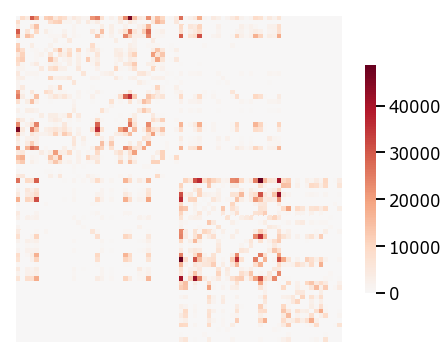

In [8]:
heatmap(g1, figsize=(8,6))

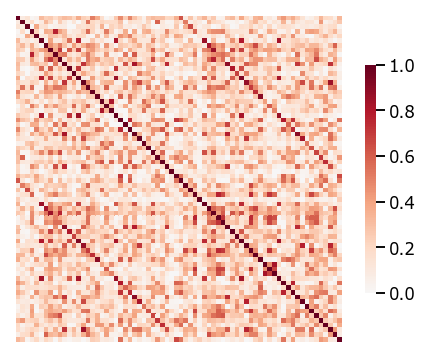

In [9]:
heatmap(g2, figsize=(8,6))

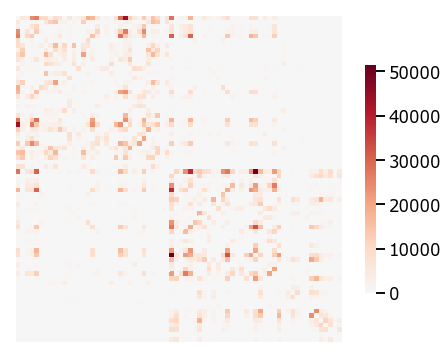

In [10]:
heatmap(g3, figsize=(8,6))

In [12]:
block_assignment_13 = estimate_block_assignment(g1, g3, num_repeats=10)

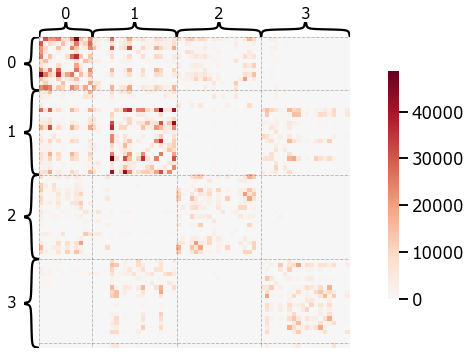

In [13]:
heatmap(g1, inner_hier_labels=block_assignment_13, figsize=(8,6))

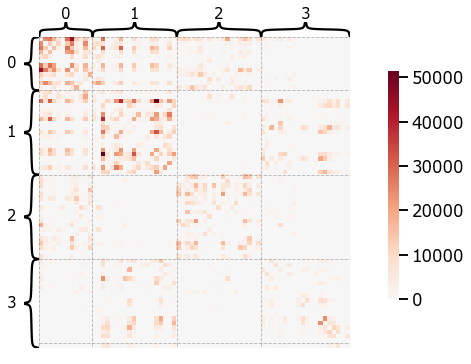

In [14]:
heatmap(g3, inner_hier_labels=block_assignment_13, figsize=(8,6))

In [15]:
mgc = MGC(compute_distance_matrix=identity)
ta, _ = mgc.test_statistic(to_distance_mtx(g1), to_distance_mtx(g3))
t0, _ = mgc.test_statistic(to_distance_mtx(block_permute(g1, block_assignment_13)),
                   to_distance_mtx(sort_graph(g3, block_assignment_13)))

print('test stats under Ha: {}'.format(ta))
print('test stats under H0: {}'.format(t0))

test stats under Ha: 0.1525870557516913
test stats under H0: 0.2262483336084478


In [16]:
block_assignment_12 = estimate_block_assignment(g1, g2, k=20, set_k=False, num_repeats=10)

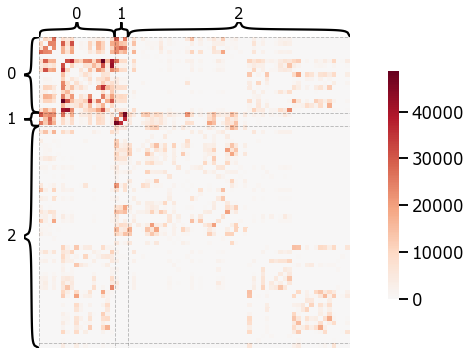

In [17]:
heatmap(g1, inner_hier_labels=block_assignment_12, figsize=(8,6))

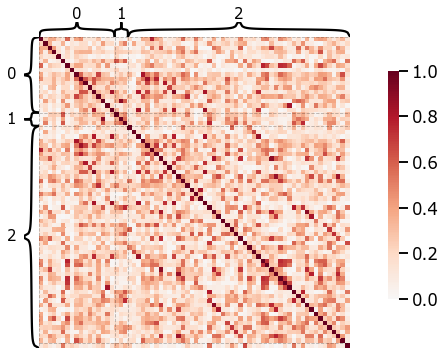

In [18]:
heatmap(g2, inner_hier_labels=block_assignment_12, figsize=(8,6))

In [19]:
mgc = MGC(compute_distance_matrix=identity)
ta, _ = mgc.test_statistic(to_distance_mtx(g1), to_distance_mtx(g2))
t0, _ = mgc.test_statistic(to_distance_mtx(block_permute(g1, block_assignment_12)),
                   to_distance_mtx(sort_graph(g2, block_assignment_12)))

print('test stats under Ha: {}'.format(ta))
print('test stats under H0: {}'.format(t0))

test stats under Ha: 0.11637997284148538
test stats under H0: 0.034678792589260966


In [20]:
k_arr = np.logspace(start=1, stop=6, num=6, base=2, dtype=int)
reps = 200
null_arr_12 = get_null_test_stats(g1, g2, k_arr, reps)

100%|██████████| 200/200 [01:35<00:00,  2.04it/s]


[]

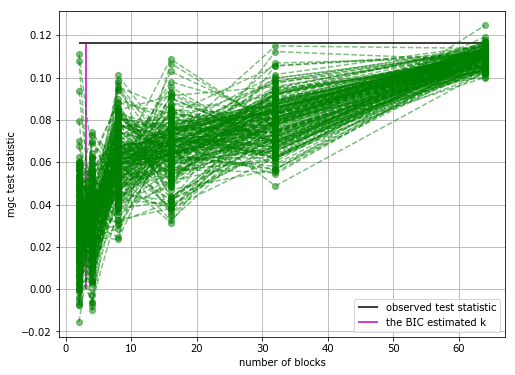

In [25]:
test_stats_null_arr = null_arr_12
test_stats_alt = mgc.test_statistic(to_distance_mtx(g1), to_distance_mtx(g2))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='o', linestyle='--', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='observed test statistic')
plt.vlines(x=np.unique(block_assignment_12).size, ymin=0, ymax=test_stats_alt, 
           label='the BIC estimated k', colors='m')
plt.xlabel('number of blocks')
plt.ylabel('mgc test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

In [22]:
k_arr = np.logspace(start=1, stop=6, num=6, base=2, dtype=int)
reps = 200
null_arr_13 = get_null_test_stats(g1, g3, k_arr, reps)

100%|██████████| 200/200 [01:49<00:00,  1.81it/s]


[]

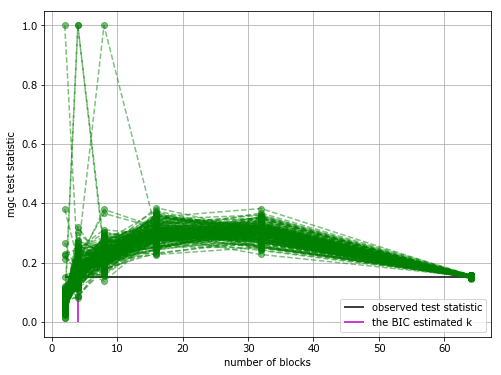

In [24]:
test_stats_null_arr = null_arr_13
test_stats_alt = mgc.test_statistic(to_distance_mtx(g1), to_distance_mtx(g3))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='o', linestyle='--', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='observed test statistic')
plt.vlines(x=np.unique(block_assignment_13).size, ymin=0, ymax=test_stats_alt, 
           label='the BIC estimated k', colors='m')
plt.xlabel('number of blocks')
plt.ylabel('mgc test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

In [48]:
subject_list = ['00254{}'.format(i) for i in np.arange(27, 57)]
session_list = [i for i in range(1, 11)]

In [43]:
session_num = 1
dwi_dirname = '../../data/mri/dwi/'
dwi_file_format = 'sub-{}_ses-{}_dwi_desikan.ssv'
fmri_dirname = '../../data/mri/fmri/'
fmri_file_format = 'sub-{}_ses-{}_bold_desikan_res-2x2x2_measure-correlation.gpickle'

for subject_id in subject_list:
    dwi_file = dwi_dirname+dwi_file_format.format(subject_id, session_num)
    fmri_file = fmri_dirname+fmri_file_format.format(subject_id, session_num)
    inputs.append((read_dwi(dwi_file), read_fmri(fmri_file)))

In [59]:
def pairs_from_list(li):
    pairs = []
    for i, x in enumerate(li):
        for j, y in enumerate(li):
            if j > i:
                pairs.append((x, y))
    return pairs